## Setup & Imports

In [8]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.decision_tree import DecisionTreeC45, DecisionTreeID3
from src.preprocessing import load_dataset, split_data, create_bias_demo_dataset
from src.visualization import print_tree, plot_feature_importance, plot_confusion_matrix
from src.utils import calculate_entropy, calculate_information_gain, calculate_gain_ratio
from sklearn.metrics import accuracy_score, confusion_matrix
import math

# Set styles
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 5)

## Part 1: Manual Calculations - Entropy

In [9]:
# Tập dữ liệu nhỏ: [A, B, A, B, B]
y = np.array(['A', 'B', 'A', 'B', 'B'])
print(f'Dữ liệu: {y}')
print(f'Phân bố: A={np.sum(y=="A")}, B={np.sum(y=="B")}')

# Tính Entropy bằng công thức
p_a = 2/5
p_b = 3/5
h_manual = -(p_a * math.log2(p_a) + p_b * math.log2(p_b))
h_func = calculate_entropy(y)

print(f'\nEntropy H(S) = -Σ(p_i * log₂(p_i))')
print(f'  p(A)={p_a:.1f}, p(B)={p_b:.1f}')
print(f'  H = -{p_a:.1f}*log₂({p_a:.1f}) - {p_b:.1f}*log₂({p_b:.1f})')
print(f'  H = {h_manual:.4f}')
print(f'✓ Hàm tính: {h_func:.4f}')

Dữ liệu: ['A' 'B' 'A' 'B' 'B']
Phân bố: A=2, B=3

Entropy H(S) = -Σ(p_i * log₂(p_i))
  p(A)=0.4, p(B)=0.6
  H = -0.4*log₂(0.4) - 0.6*log₂(0.6)
  H = 0.9710
✓ Hàm tính: 0.9710


## Part 2: Manual Calculations - Information Gain

In [10]:
# Feature: color [red, red, blue, red, blue]
X_color = np.array(['red', 'red', 'blue', 'red', 'blue'])
print(f'Feature "color": {X_color}')

# Chia dữ liệu theo giá trị
red_y = y[X_color == 'red']      # ['A', 'B', 'B']
blue_y = y[X_color == 'blue']    # ['A', 'B']

h_red = calculate_entropy(red_y)
h_blue = calculate_entropy(blue_y)
w_red = len(red_y) / len(y)
w_blue = len(blue_y) / len(y)

print(f'\nRed (3 mẫu): {red_y} → H_red={h_red:.4f}')
print(f'Blue (2 mẫu): {blue_y} → H_blue={h_blue:.4f}')

# Information Gain
h_base = calculate_entropy(y)
ig = h_base - (w_red * h_red + w_blue * h_blue)
print(f'\nInformation Gain: IG = H(S) - Σ(|S_v|/|S| * H(S_v))')
print(f'  IG = {h_base:.4f} - ({w_red:.1f}*{h_red:.4f} + {w_blue:.1f}*{h_blue:.4f})')
print(f'  IG = {ig:.4f}')

Feature "color": ['red' 'red' 'blue' 'red' 'blue']

Red (3 mẫu): ['A' 'B' 'B'] → H_red=0.9183
Blue (2 mẫu): ['A' 'B'] → H_blue=1.0000

Information Gain: IG = H(S) - Σ(|S_v|/|S| * H(S_v))
  IG = 0.9710 - (0.6*0.9183 + 0.4*1.0000)
  IG = 0.0200


## Part 3: Manual Calculations - Gain Ratio

In [11]:
# Split Info
split_info = -(w_red * math.log2(w_red) + w_blue * math.log2(w_blue))
gr = ig / split_info if split_info > 0 else 0

print(f'Split Info (độ phân tán): -Σ(|S_v|/|S| * log₂(|S_v|/|S|))')
print(f'  SplitInfo = -{w_red:.1f}*log₂({w_red:.1f}) - {w_blue:.1f}*log₂({w_blue:.1f})')
print(f'  SplitInfo = {split_info:.4f}')

print(f'\nGain Ratio (C4.5): GR = IG / SplitInfo')
print(f'  GR = {ig:.4f} / {split_info:.4f} = {gr:.4f}')

print(f'\n✓ ĐIỂM KHÁC BIỆT: C4.5 chia IG cho SplitInfo để tránh bias!')

Split Info (độ phân tán): -Σ(|S_v|/|S| * log₂(|S_v|/|S|))
  SplitInfo = -0.6*log₂(0.6) - 0.4*log₂(0.4)
  SplitInfo = 0.9710

Gain Ratio (C4.5): GR = IG / SplitInfo
  GR = 0.0200 / 0.9710 = 0.0206

✓ ĐIỂM KHÁC BIỆT: C4.5 chia IG cho SplitInfo để tránh bias!


## Part 4: Load & EDA

In [12]:
# Load dataset
X, y, feature_names, class_names = load_dataset('../data/car_price_prediction_.csv')
print(f'Dataset: {len(X)} mẫu, {len(feature_names)} thuộc tính')
print(f'Thuộc tính: {feature_names}')
print(f'Classes: {class_names}')

# Basic stats
print(f'\nThống kê:')
print(X.describe())

Dataset: 2500 mẫu, 7 thuộc tính
Thuộc tính: ['Brand', 'Year', 'Engine Size', 'Fuel Type', 'Transmission', 'Mileage', 'Price']
Classes: ['Like New', 'New', 'Used']

Thống kê:
            Year  Engine Size        Mileage         Price
count  2500.0000  2500.000000    2500.000000   2500.000000
mean   2011.6268     3.465240  149749.844800  52638.022532
std       6.9917     1.432053   87919.952034  27295.833455
min    2000.0000     1.000000      15.000000   5011.270000
25%    2005.0000     2.200000   71831.500000  28908.485000
50%    2012.0000     3.400000  149085.000000  53485.240000
75%    2018.0000     4.700000  225990.500000  75838.532500
max    2023.0000     6.000000  299967.000000  99982.590000


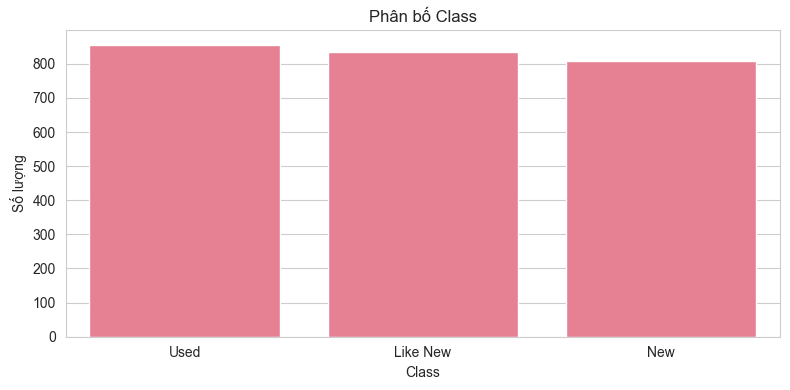

In [13]:
# Phân bố class
plt.figure(figsize=(8, 4))
y_counts = y.value_counts()
sns.barplot(x=y_counts.index, y=y_counts.values)
plt.title('Phân bố Class')
plt.xlabel('Class')
plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

## Part 5: BIAS DEMONSTRATION - ID3 vs C4.5

In [14]:
# Tạo dataset nhỏ để chứng minh bias
X_bias, y_bias, feature_names_bias = create_bias_demo_dataset()
print(f'Dataset bias demo:')
print(X_bias)
print(f'Target: {list(y_bias)}')
print(f'\nFeature hữu ích: "weather" (3 values)')
print(f'Feature vô dụng: "id" (8 unique values - cao!)')

Dataset bias demo:
  weather  id
0   sunny   1
1   sunny   2
2   rainy   3
3  cloudy   4
4   sunny   5
5   rainy   6
6  cloudy   7
7   sunny   8
Target: ['go', 'go', 'stay', 'stay', 'go', 'stay', 'stay', 'go']

Feature hữu ích: "weather" (3 values)
Feature vô dụng: "id" (8 unique values - cao!)


In [15]:
# Tính IG và GR cho từng feature
Xm = X_bias.values
ig_weather = calculate_information_gain(Xm, list(y_bias), 0)  # weather
ig_id = calculate_information_gain(Xm, list(y_bias), 1)        # id

gr_weather = calculate_gain_ratio(Xm, list(y_bias), 0)        # weather
gr_id = calculate_gain_ratio(Xm, list(y_bias), 1)              # id

print('INFORMATION GAIN (ID3):')
print(f'  weather: IG = {ig_weather:.4f}')
print(f'  id:      IG = {ig_id:.4f}')
print(f'  ➜ ID3 chọn: {"id" if ig_id > ig_weather else "weather"} (BỊ LỪA!)')

print(f'\nGAIN RATIO (C4.5):')
print(f'  weather: GR = {gr_weather:.4f}')
print(f'  id:      GR = {gr_id:.4f}')
print(f'  ➜ C4.5 chọn: {"id" if gr_id > gr_weather else "weather"} (ĐÚNG!)')

INFORMATION GAIN (ID3):
  weather: IG = 1.0000
  id:      IG = 1.0000
  ➜ ID3 chọn: weather (BỊ LỪA!)

GAIN RATIO (C4.5):
  weather: GR = 0.6667
  id:      GR = 0.3333
  ➜ C4.5 chọn: weather (ĐÚNG!)


In [16]:
# Train ID3 và C4.5
id3 = DecisionTreeID3(max_depth=3)
id3.fit(X_bias, y_bias)

c45 = DecisionTreeC45(max_depth=3)
c45.fit(X_bias, y_bias)

print('ID3 Tree:')
print(f'Root feature: {id3.root.feature_name}')
print_tree(id3.root)

print(f'\nC4.5 Tree:')
print(f'Root feature: {c45.root.feature_name}')
print_tree(c45.root)

ID3 Tree:
Root feature: weather
weather == cloudy
  [Lá] lớp = stay, N = 2
weather == rainy
  [Lá] lớp = stay, N = 2
weather == sunny
  [Lá] lớp = go, N = 4

C4.5 Tree:
Root feature: weather
weather == cloudy
  [Lá] lớp = stay, N = 2
weather == rainy
  [Lá] lớp = stay, N = 2
weather == sunny
  [Lá] lớp = go, N = 4


## Part 6: Train Models on Real Dataset

In [17]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Train C4.5
tree_c45 = DecisionTreeC45(max_depth=10)
tree_c45.fit(X_train, y_train)

# Train ID3
tree_id3 = DecisionTreeID3(max_depth=10)
tree_id3.fit(X_train, y_train)

print('✓ Models trained!')

✓ Models trained!


In [18]:
# Predict
y_pred_c45 = tree_c45.predict(X_test)
y_pred_id3 = tree_id3.predict(X_test)

# Accuracy
acc_c45 = accuracy_score(y_test, y_pred_c45)
acc_id3 = accuracy_score(y_test, y_pred_id3)

print(f'C4.5 Accuracy: {acc_c45:.3f}')
print(f'ID3 Accuracy:  {acc_id3:.3f}')

# Tree info
info_c45 = tree_c45.get_tree_info()
info_id3 = tree_id3.get_tree_info()

print(f'\nC4.5 Tree: depth={info_c45["depth"]}, nodes={info_c45["n_nodes"]}')
print(f'ID3 Tree:  depth={info_id3["depth"]}, nodes={info_id3["n_nodes"]}')

C4.5 Accuracy: 0.342
ID3 Accuracy:  0.358

C4.5 Tree: depth=10, nodes=21
ID3 Tree:  depth=10, nodes=989


## Part 7: Feature Importance

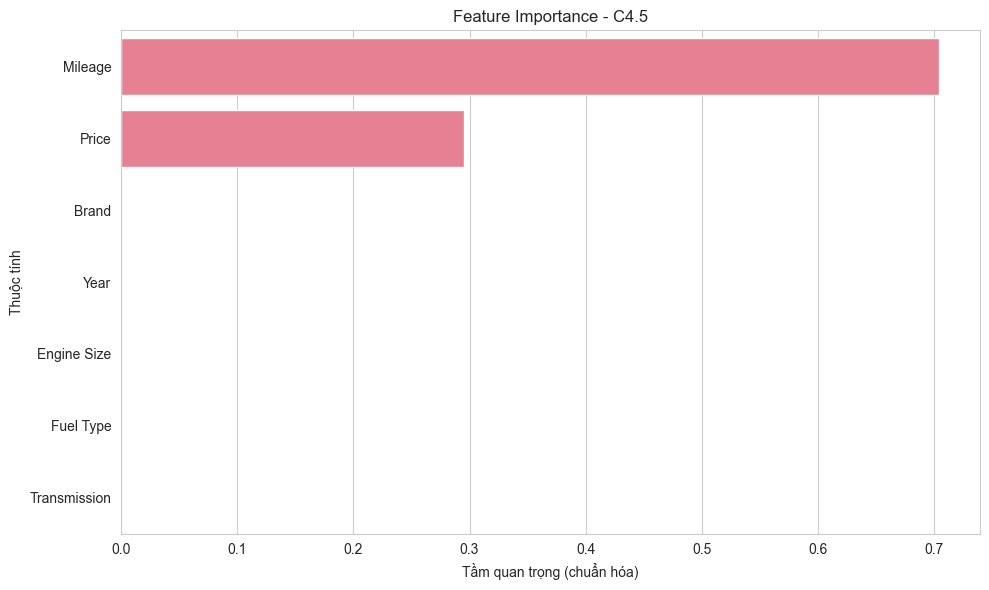

In [19]:
# Feature importance
importance = tree_c45.get_feature_importance()
top_n = 10
items = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = [k for k, _ in items]
values = [v for _, v in items]

plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=labels)
plt.xlabel('Tầm quan trọng (chuẩn hóa)')
plt.ylabel('Thuộc tính')
plt.title('Feature Importance - C4.5')
plt.tight_layout()
plt.show()

## Part 8: Confusion Matrix

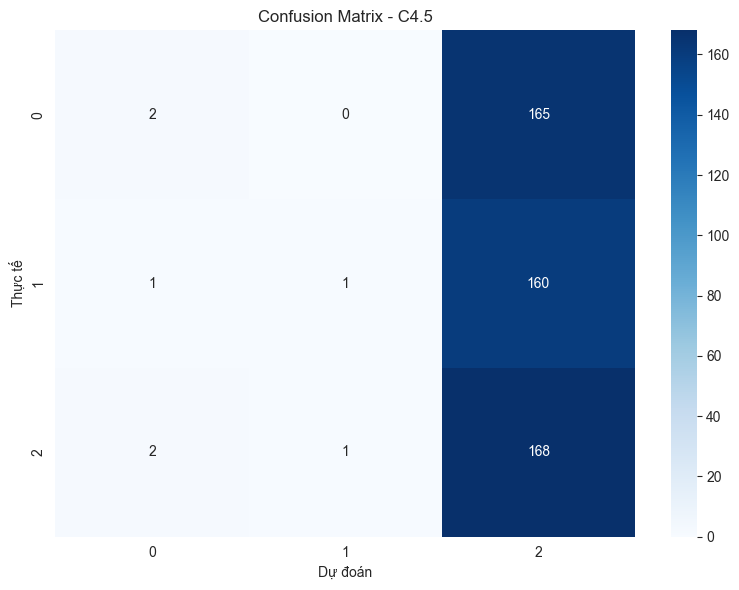

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_c45)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - C4.5')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()